In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.ticker as mtick
from urllib import request
import geopandas
import zipfile, re, os
from bs4 import BeautifulSoup

In [2]:
url = "https://www.otodom.pl/pl/wyniki/sprzedaz/mieszkanie/malopolskie/krakow/krakow/krakow?viewType=listing"
pages = []

for page_number in range(1, 18):
    req = request.Request(f'{url}&page={page_number}', headers={'User-Agent': 'Mozilla/5.0'})
    print(f'Pobieranie strony {page_number}')
    with request.urlopen(req) as resp:
        processed_page = BeautifulSoup(resp.read().decode('utf-8'), "html.parser")
        pages.append(processed_page)

Pobieranie strony 1
Pobieranie strony 2
Pobieranie strony 3
Pobieranie strony 4
Pobieranie strony 5
Pobieranie strony 6
Pobieranie strony 7
Pobieranie strony 8
Pobieranie strony 9
Pobieranie strony 10
Pobieranie strony 11
Pobieranie strony 12
Pobieranie strony 13
Pobieranie strony 14
Pobieranie strony 15
Pobieranie strony 16
Pobieranie strony 17


In [9]:
data = []
for page in pages:
    data += page.find_all(class_="css-136g1q2 e88tro00")

In [86]:
import re

listings_data = []
districts_krakow = ['Stare Miasto', 'Grzegórzki', 'Prądnik Czerwony', 'Prądnik Biały', 'Krowodrza', 'Bronowice', 'Zwierzyniec', 'Dębniki', 'Łagiewniki-Borek Fałęcki', 'Swoszowice', 'Podgórze Duchackie', 'Bieżanów-Prokocim', 'Podgórze', 'Czyżyny', 'Mistrzejowice', 'Bieńczyce', 'Wzgórza Krzesławickie', 'Nowa Huta']

def find_district(address):
    for district in districts_krakow:
        if district.lower() in address.lower():
            return district
    return None

for listing in data:
    address = listing.find('p', {'data-testid': 'advert-card-address', 'class': "css-1dvtw4c e12u5vlm0"}).get_text(strip=True) if listing.find('p', {'data-testid': 'advert-card-address'}) else 'N/A'
    url_element = listing.find('a', attrs={'data-cy': 'listing-item-link'}).get('href')
    url = 'https://www.otodom.pl' + url_element if url_element else None
    district = find_district(address)

    specs = listing.find('div', {'class': "css-1c1kq07 e12r8p6s0"})
    if specs:
        rooms = specs.find('dd').text

        area_element = specs.find_all('dd')[1].text
        area_clean = re.sub(r'[^\d.]', '', area_element)
        area = float(area_clean)

        if specs.find('dt', text='Cena za metr kwadratowy'):
          price_per_meter_element = specs.find_all('dd')[2].text
          price_per_meter = re.sub(r'[^\d.]', '', price_per_meter_element)
        else:
          price_per_meter = None

        floor_element = specs.find('dd', string=re.compile(r'\bpiętro\b'))
        floor = floor_element.get_text(strip=True) if floor_element else 'N/A'
    else:
        rooms, area, price_per_meter, floor = 'N/A', 'N/A', 'N/A', 'N/A'

    price = listing.find(class_="css-1uwck7i e1a3ad6s0").text
    price_clean = re.sub(r'[^\d.]', '', price)
    if price_clean:
        listing['price'] = float(price_clean)
    else:
        listing['price'] = None

    listings_data.append({
        'Adres': address,
        'Liczba pokoi': rooms,
        'Powierzchnia': area,
        'Cena za metr kwadratowy': price_per_meter,
        'Piętro': floor,
        'Cena': price,
        'URL': url,
        'Dzielnica': district
    })

df = pd.DataFrame(listings_data)
print(df.head())


<ipython-input-86-b6c70621597e>:26: DeprecationWarning: The 'text' argument to find()-type methods is deprecated. Use 'string' instead.
  if specs.find('dt', text='Cena za metr kwadratowy'):


                                               Adres Liczba pokoi  \
0  ul. Mochnaniec, Skotniki, Dębniki, Kraków, mał...      1 pokój   
1  ul. Na Wrzosach, Prokocim, Bieżanów-Prokocim, ...      1 pokój   
2  ul. św. Jana, Stare Miasto, Stare Miasto, Krak...     2 pokoje   
3  ul. Piasta Kołodzieja, Mistrzejowice, Mistrzej...     4 pokoje   
4  ul. Józefa Chełmońskiego, Azory, Prądnik Biały...     2 pokoje   

   Powierzchnia Cena za metr kwadratowy    Piętro            Cena  \
0         33.74                    None  1 piętro  Zapytaj o cenę   
1         13.70                   13504       N/A      185 000 zł   
2         84.00                   35571  2 piętro    2 988 000 zł   
3         78.97                    None  4 piętro  Zapytaj o cenę   
4         52.57                   13506  1 piętro      710 000 zł   

                                                 URL          Dzielnica  
0  https://www.otodom.pl/pl/oferta/1-pokojowe-mie...            Dębniki  
1  https://www.otodom.

In [87]:
df

,Adres,Liczba pokoi,Powierzchnia,Cena za metr kwadratowy,Piętro,Cena,URL,Dzielnica
0,"ul. Mochnaniec, Skotniki, Dębniki, Kraków, mał...",1 pokój,33.74,None,1 piętro,Zapytaj o cenę,https://www.otodom.pl/pl/oferta/1-pokojowe-mie...,Dębniki
1,"ul. Na Wrzosach, Prokocim, Bieżanów-Prokocim, ...",1 pokój,13.70,13504,N/A,185 000 zł,https://www.otodom.pl/pl/oferta/funkcjonalna-k...,Bieżanów-Prokocim
2,"ul. św. Jana, Stare Miasto, Stare Miasto, Krak...",2 pokoje,84.00,35571,2 piętro,2 988 000 zł,https://www.otodom.pl/pl/oferta/apartament-lux...,Stare Miasto
3,"ul. Piasta Kołodzieja, Mistrzejowice, Mistrzej...",4 pokoje,78.97,None,4 piętro,Zapytaj o cenę,https://www.otodom.pl/pl/oferta/4-pokojowe-mie...,Mistrzejowice
4,"ul. Józefa Chełmońskiego, Azory, Prądnik Biały...",2 pokoje,52.57,13506,1 piętro,710 000 zł,https://www.otodom.pl/pl/oferta/2-pokojowe-mie...,Prądnik Biały
...,...,...,...,...,...,...,...,...
591,"os. Górali 5, os. Urocze, os. Teatralne, os. Z...",1 pokój,17.57,23278,3 piętro,409 000 zł,https://www.otodom.pl/pl/oferta/kawalerka-po-r...,Nowa Huta
592,"Prądnik Czerwony, Prądnik Czerwony, Kraków, ma...",3 pokoje,35.50,14056,2 piętro,499 000 zł,https://www.otodom.pl/pl/oferta/m3-i-blisko-ce...,Prądnik Czerwony
593,"ul. Ułanów 72,, Rakowice, Prądnik Czerwony, Kr...",2 pokoje,29.70,15118,N/A,449 000 zł,https://www.otodom.pl/pl/oferta/2-pokoje-po-re...,Prądnik Czerwony
594,"ul. Wlotowa, Kozłówka, Bieżanów-Prokocim, Krak...",1 pokój,25.10,16693,2 piętro,419 000 zł,https://www.otodom.pl/pl/oferta/gotowa-kawaler...,Bieżanów-Prokocim


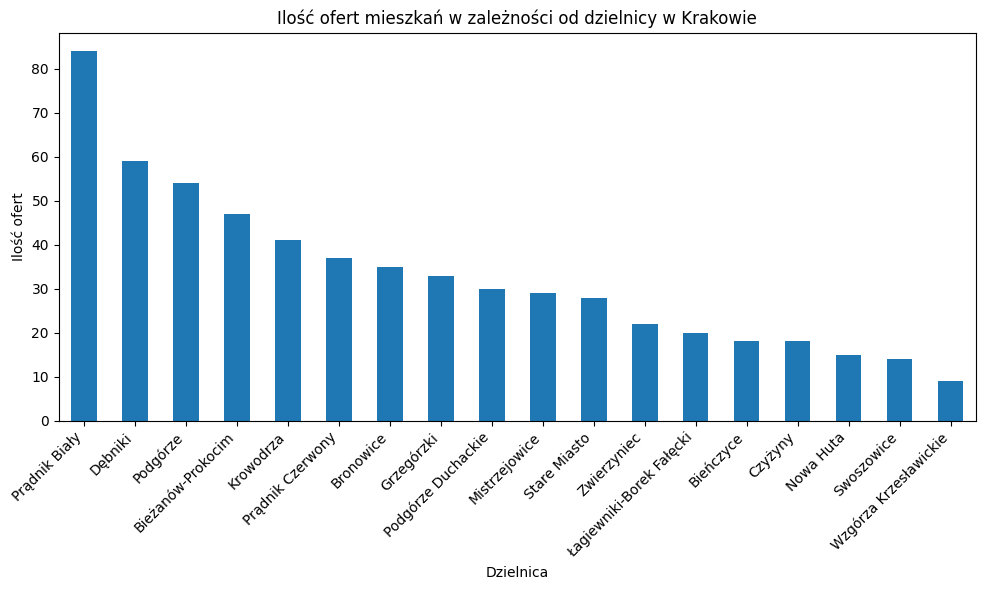

In [144]:
offers_per_district = df['Dzielnica'].value_counts()

plt.figure(figsize=(10, 6))
offers_per_district.plot(kind='bar')
plt.title('Ilość ofert mieszkań w zależności od dzielnicy w Krakowie')
plt.xlabel('Dzielnica')
plt.ylabel('Ilość ofert')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [95]:
pradnik_df = df[(df['Dzielnica'] == "Prądnik Biały")]
pradnik_df

,Adres,Liczba pokoi,Powierzchnia,Cena za metr kwadratowy,Piętro,Cena,URL,Dzielnica
4,"ul. Józefa Chełmońskiego, Azory, Prądnik Biały...",2 pokoje,52.57,13506,1 piętro,710 000 zł,https://www.otodom.pl/pl/oferta/2-pokojowe-mie...,Prądnik Biały
17,"ul. Josepha Conrada, Azory, Prądnik Biały, Kra...",3 pokoje,60.14,13170,4 piętro,792 043 zł,https://www.otodom.pl/pl/oferta/3-pokojowe-mie...,Prądnik Biały
27,"ul. Wiarusa, Prądnik Biały, Prądnik Biały, Kra...",4 pokoje,83.61,13650,3 piętro,1 141 277 zł,https://www.otodom.pl/pl/oferta/4-pokojowe-mie...,Prądnik Biały
29,"ul. Władysława Łokietka, Tonie, Prądnik Biały,...",4 pokoje,89.78,13121,N/A,1 178 000 zł,https://www.otodom.pl/pl/oferta/4-pokojowe-mie...,Prądnik Biały
38,"ul. Józefa Chełmońskiego, Bronowice Wielkie, P...",3 pokoje,63.00,16984,1 piętro,1 070 000 zł,https://www.otodom.pl/pl/oferta/naslonecznione...,Prądnik Biały
...,...,...,...,...,...,...,...,...
554,"ul. Stefana Banacha, Górka Narodowa, Prądnik B...",2 pokoje,36.39,17450,3 piętro,635 000 zł,https://www.otodom.pl/pl/oferta/uwaga-zaintere...,Prądnik Biały
568,"ul. Stefana Banacha, Górka Narodowa, Prądnik B...",3 pokoje,67.50,None,N/A,Zapytaj o cenę,https://www.otodom.pl/pl/oferta/3-pokojowe-mie...,Prądnik Biały
575,"ul. ks. Józefa Meiera, Górka Narodowa, Prądnik...",2 pokoje,53.69,12852,3 piętro,690 000 zł,https://www.otodom.pl/pl/oferta/dwa-osobne-pok...,Prądnik Biały
580,"ul. Gnieźnieńska 22, ul. Opolska, ul. Jaremy, ...",2 pokoje,35.40,19435,4 piętro,688 000 zł,https://www.otodom.pl/pl/oferta/2-pokoje-do-we...,Prądnik Biały


In [109]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

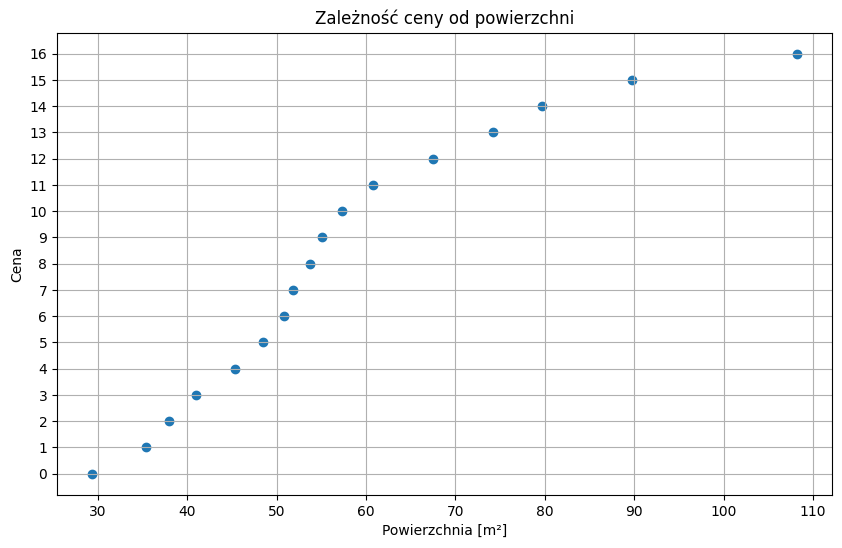

In [115]:
df_sorted = pradnik_df.sort_values(by='Powierzchnia')

step = 5

df_sampled = df_sorted.iloc[::step, :]

plt.figure(figsize=(10, 6))
plt.scatter(df_sampled['Powierzchnia'], df_sampled['Cena'])
plt.title('Zależność ceny od powierzchni')
plt.xlabel('Powierzchnia [m²]')
plt.ylabel('Cena')
plt.grid(True)

plt.gca().get_yaxis().set_major_formatter(ticker.FuncFormatter(lambda x, _: format(int(x), ',')))

plt.show()

In [ ]:
df['Cena za metr kwadratowy'] = df['Cena za metr kwadratowy'].str.replace(r'[^\d.]', '', regex=True)
df['Cena za metr kwadratowy'] = pd.to_numeric(df['Cena za metr kwadratowy'], errors='coerce')

average_price_per_district = df.groupby('Dzielnica')['Cena za metr kwadratowy'].mean()

In [158]:
print(average_price_per_district)

Dzielnica
Bieńczyce                   15242.222222
Bieżanów-Prokocim           14455.813953
Bronowice                   16290.066667
Czyżyny                     16703.388889
Dębniki                     15988.125000
Grzegórzki                  36919.375000
Krowodrza                   18687.048780
Mistrzejowice               14645.629630
Nowa Huta                   14055.333333
Podgórze                    16339.039216
Podgórze Duchackie          13741.642857
Prądnik Biały               14934.060976
Prądnik Czerwony            16511.129032
Stare Miasto                24236.428571
Swoszowice                  12163.923077
Wzgórza Krzesławickie       12577.714286
Zwierzyniec                 22177.909091
Łagiewniki-Borek Fałęcki    13923.363636
Name: Cena za metr kwadratowy, dtype: float64


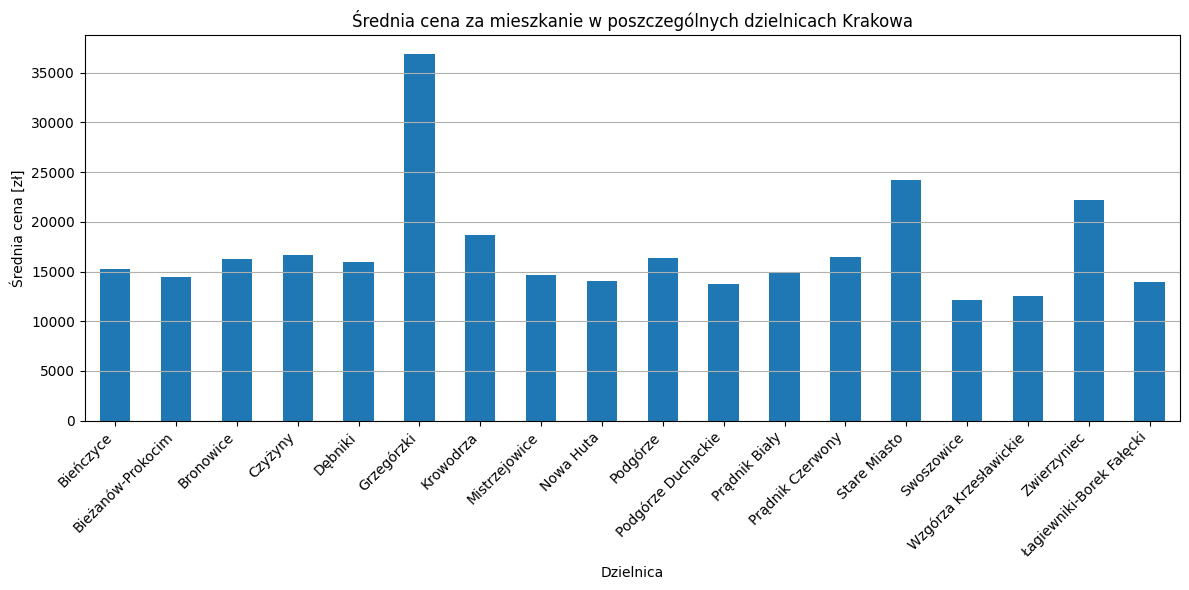

In [157]:
plt.figure(figsize=(12, 6))
average_price_per_district.plot(kind='bar')
plt.title('Średnia cena za mieszkanie w poszczególnych dzielnicach Krakowa')
plt.xlabel('Dzielnica')
plt.ylabel('Średnia cena [zł]')
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y')
plt.tight_layout()
plt.show()